In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset
df=pd.read_csv("C:/Users/Administrator/Documents/Personal/datasets/House_Rent_Dataset.csv")
df.head()


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [2]:
#checking for null values and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [3]:
df.isnull().sum()


Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [4]:
df.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [5]:
#check for duplication
df.duplicated().sum()

0

In [6]:
#feature engineering

#price according to area 
df['price per sqft']= df['Rent']/df['Size']

#age of the property from the day it was posted
from datetime import datetime
current_date = datetime.now()
df['Posted On'] = pd.to_datetime(df[ 'Posted On']) 
df['Age of Property'] =(current_date - df['Posted On']).dt.days

#Ratio of bathroom to bedroom
df['Bathroom to Bedroom Ratio']=df['Bathroom'] / df['BHK']

#Average rent in locality
locality_avg_rent = df.groupby('Area Locality')['Rent'].mean().reset_index() 
locality_avg_rent.columns=['Area Locality', 'Avg Rent'] 
df = pd.merge(df, locality_avg_rent, on='Area Locality', how='left')

#Most common BHK found in a locality
most_common_bhk_df = df.groupby('Area Locality')['BHK'].agg (lambda x: x.value_counts().index[0]).reset_index()
most_common_bhk_df.rename(columns={'BHK': 'Most Common BHK'}, inplace=True) 
df= pd.merge(df, most_common_bhk_df, on='Area Locality', how='left')

df

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,price per sqft,Age of Property,Bathroom to Bedroom Ratio,Avg Rent,Most Common BHK
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,9.090909,624,1.000000,8250.000000,2
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,25.000000,629,0.500000,11750.000000,2
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,17.000000,626,0.500000,23187.500000,3
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,12.500000,577,0.500000,16000.000000,2
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,8.823529,633,0.500000,7500.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2022-05-18,2,15000,1000,3 out of 5,Carpet Area,Bandam Kommu,Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner,15.000000,624,1.000000,15750.000000,3
4742,2022-05-15,3,29000,2000,1 out of 4,Super Area,"Manikonda, Hyderabad",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner,14.500000,627,1.000000,29000.000000,3
4743,2022-07-10,3,35000,1750,3 out of 5,Carpet Area,"Himayath Nagar, NH 7",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent,20.000000,571,1.000000,30555.555556,3
4744,2022-07-06,3,45000,1500,23 out of 34,Carpet Area,Gachibowli,Hyderabad,Semi-Furnished,Family,2,Contact Agent,30.000000,575,0.666667,43879.310345,3


In [7]:
#display basic stats of target variable
df['Rent'].describe()

count    4.746000e+03
mean     3.499345e+04
std      7.810641e+04
min      1.200000e+03
25%      1.000000e+04
50%      1.600000e+04
75%      3.300000e+04
max      3.500000e+06
Name: Rent, dtype: float64

In [8]:

#feature encoding
cat_cols = ['Floor', 'Area Type', 'Area Locality', 'City', 
            'Furnishing Status', 'Tenant Preferred', 'Point of Contact']
     

for col in cat_cols:
  print(df[col].value_counts())

Floor
1 out of 2         379
Ground out of 2    350
2 out of 3         312
2 out of 4         308
1 out of 3         293
                  ... 
11 out of 31         1
50 out of 75         1
18 out of 26         1
12 out of 27         1
23 out of 34         1
Name: count, Length: 480, dtype: int64
Area Type
Super Area     2446
Carpet Area    2298
Built Area        2
Name: count, dtype: int64
Area Locality
Bandra West                                37
Gachibowli                                 29
Electronic City                            24
Velachery                                  22
Miyapur, NH 9                              22
                                           ..
Kengeri Upanagara                           1
Ittamadu, Banashankari, Outer Ring Road     1
Rmv Extension, Armane Nagar                 1
snv la                                      1
Manikonda, Hyderabad                        1
Name: count, Length: 2235, dtype: int64
City
Mumbai       972
Chennai      891
Bangalo

In [11]:
#encoding the categorical variables into numerical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for cat_col in cat_cols:
  df[cat_col] = le.fit_transform(df[cat_col])
     
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,price per sqft,Age of Property,Bathroom to Bedroom Ratio,Avg Rent,Most Common BHK
0,2022-05-18,2,10000,1100,455,2,221,4,2,1,2,2,9.090909,624,1.0,8250.0,2
1,2022-05-13,2,20000,800,14,2,1527,4,1,1,1,2,25.000000,629,0.5,11750.0,2
2,2022-05-16,2,17000,1000,14,2,1760,4,1,1,1,2,17.000000,626,0.5,23187.5,3
3,2022-07-04,2,10000,800,10,2,526,4,2,1,1,2,12.500000,577,0.5,16000.0,2
4,2022-05-09,2,7500,850,10,1,1890,4,2,0,1,2,8.823529,633,0.5,7500.0,2


array([[<Axes: title={'center': 'Posted On'}>,
        <Axes: title={'center': 'BHK'}>,
        <Axes: title={'center': 'Rent'}>,
        <Axes: title={'center': 'Size'}>],
       [<Axes: title={'center': 'Floor'}>,
        <Axes: title={'center': 'Area Type'}>,
        <Axes: title={'center': 'Area Locality'}>,
        <Axes: title={'center': 'City'}>],
       [<Axes: title={'center': 'Furnishing Status'}>,
        <Axes: title={'center': 'Tenant Preferred'}>,
        <Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Point of Contact'}>],
       [<Axes: title={'center': 'price per sqft'}>,
        <Axes: title={'center': 'Age of Property'}>,
        <Axes: title={'center': 'Bathroom to Bedroom Ratio'}>,
        <Axes: title={'center': 'Avg Rent'}>],
       [<Axes: title={'center': 'Most Common BHK'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

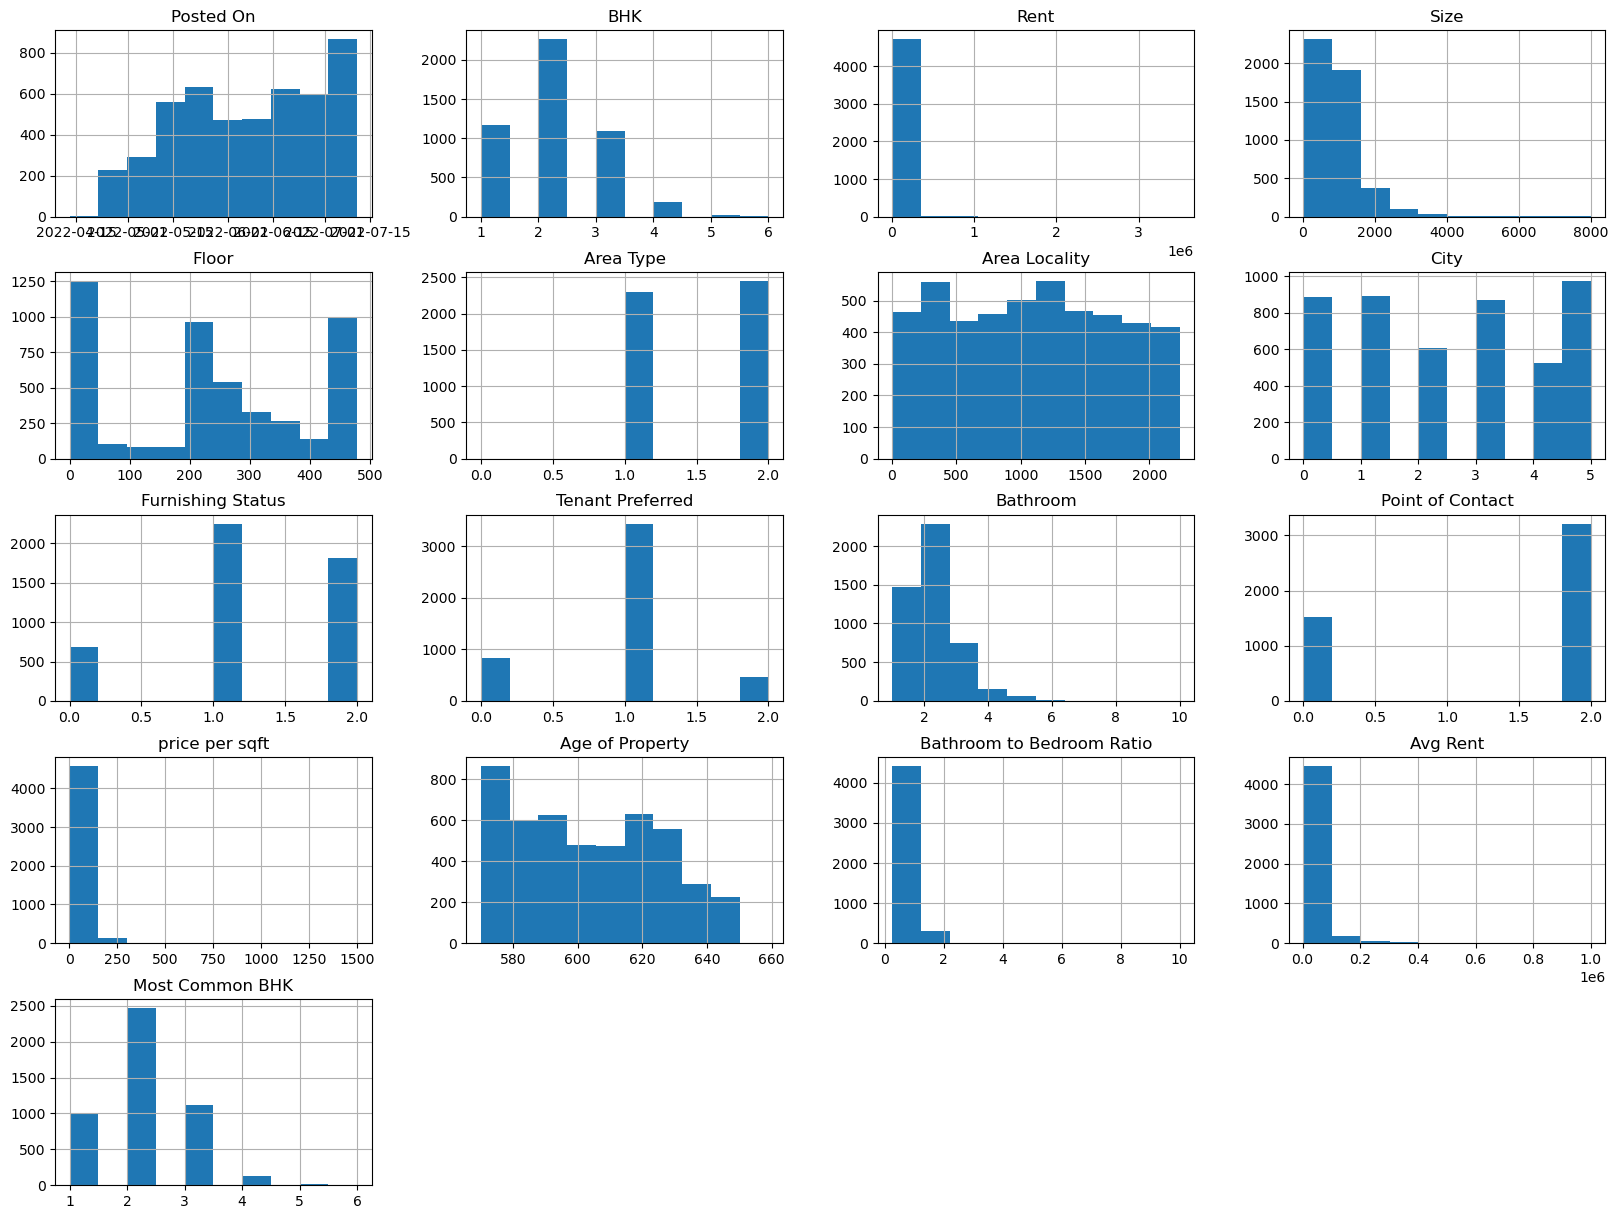

In [12]:
#histogram of each feature showing distributions 
df.hist(figsize=(20,15))

array([[<Axes: title={'center': 'Posted On'}>,
        <Axes: title={'center': 'BHK'}>,
        <Axes: title={'center': 'Rent'}>,
        <Axes: title={'center': 'Size'}>],
       [<Axes: title={'center': 'Floor'}>,
        <Axes: title={'center': 'Area Type'}>,
        <Axes: title={'center': 'Area Locality'}>,
        <Axes: title={'center': 'City'}>],
       [<Axes: title={'center': 'Furnishing Status'}>,
        <Axes: title={'center': 'Tenant Preferred'}>,
        <Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Point of Contact'}>],
       [<Axes: title={'center': 'price per sqft'}>,
        <Axes: title={'center': 'Age of Property'}>,
        <Axes: title={'center': 'Bathroom to Bedroom Ratio'}>,
        <Axes: title={'center': 'Avg Rent'}>],
       [<Axes: title={'center': 'Most Common BHK'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

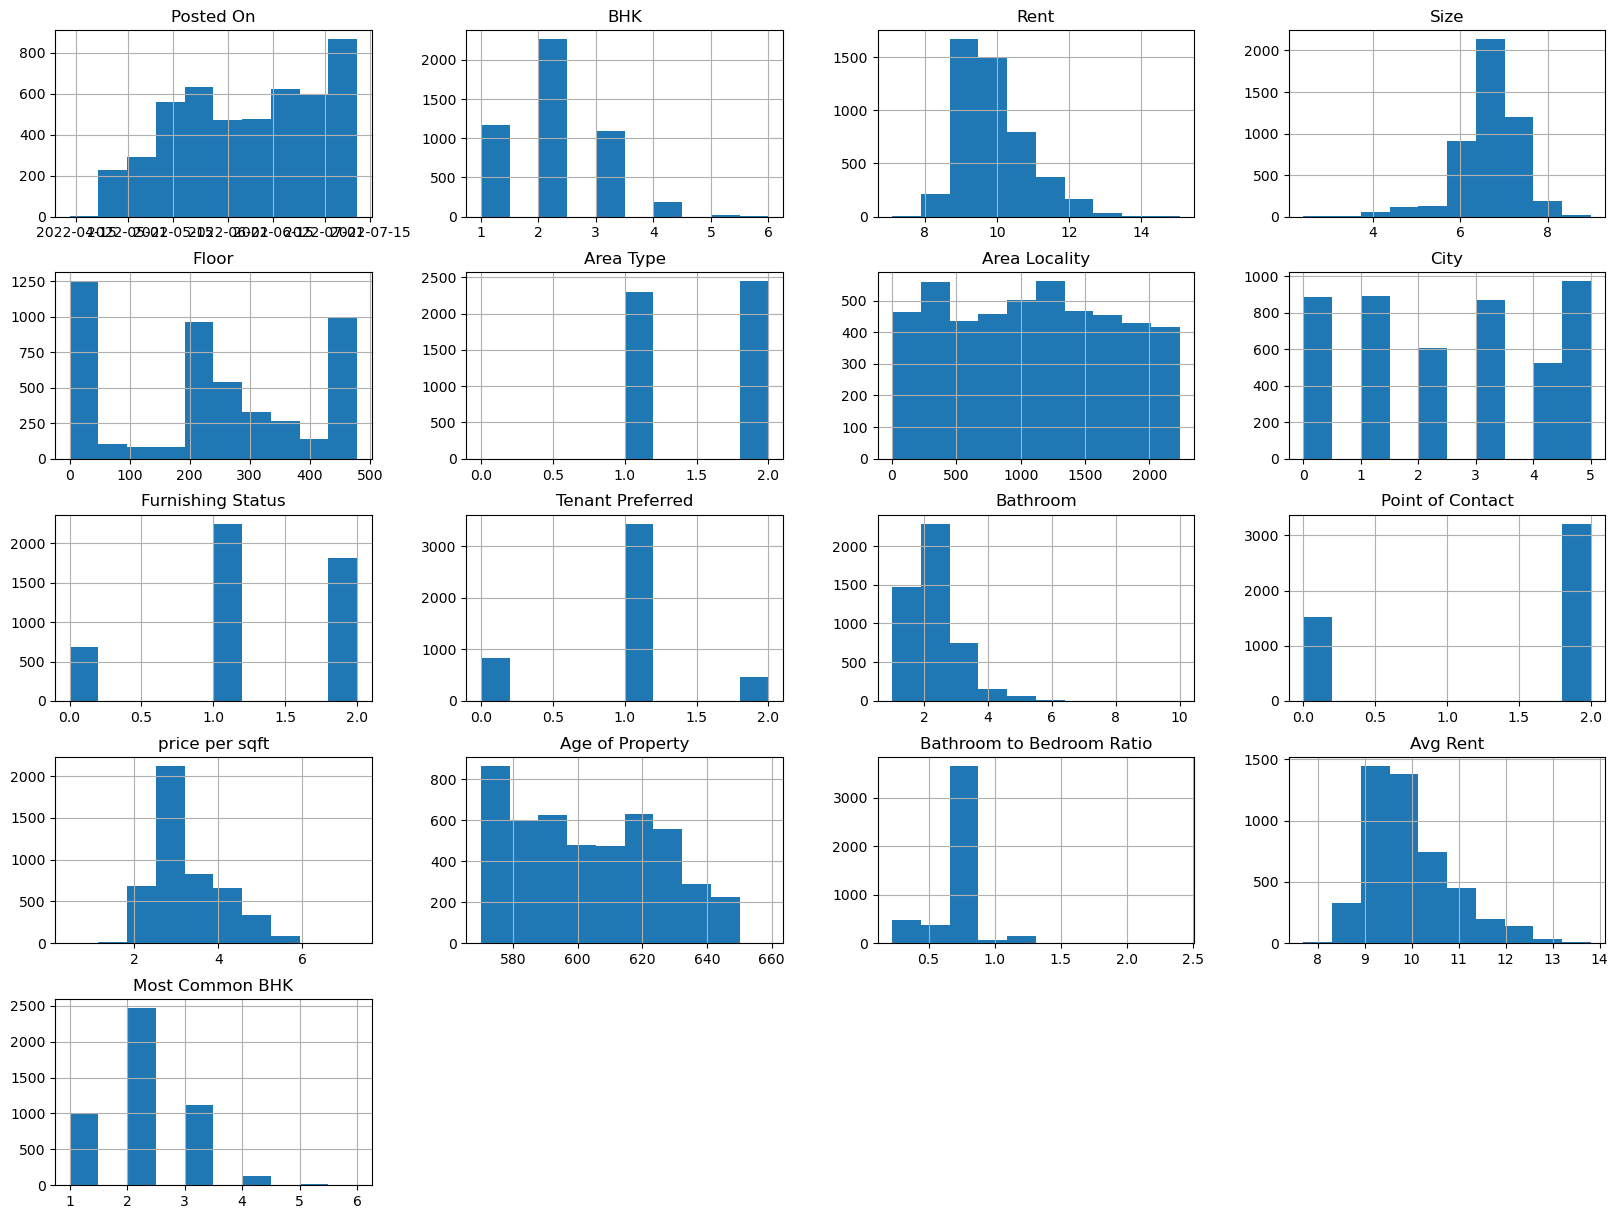

In [14]:
#taking logarithmic scale

df1=df
df1['Size'] =np.log(df1['Size'] + 1)
df1['Rent']= np.log(df1['Rent'] + 1)
df1['price per sqft']= np.log(df1['price per sqft']+ 1)
df1['Bathroom to Bedroom Ratio']= np.log(df1['Bathroom to Bedroom Ratio']+ 1) 
df1['Avg Rent']= np.log(df1['Avg Rent']+1) 
df1.hist(figsize=(20,15))

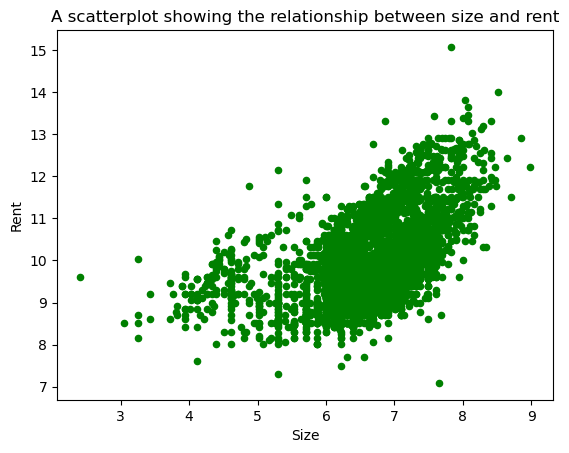

In [16]:
#scatter plots of some features against the target variable 
subset =df1[['Size', 'Rent']]
scatter = subset.plot(x = 'Size', y = 'Rent', kind='scatter', c= 'green'); 
scatter.set_title("A scatterplot showing the relationship between size and rent");

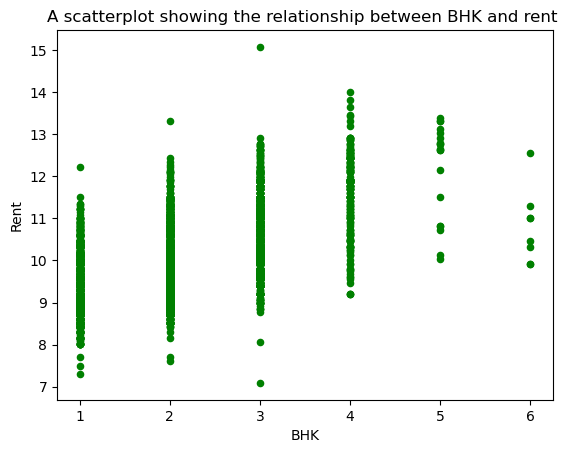

In [17]:
subset =df1[['BHK', 'Rent']]
scatter= subset.plot(x ='BHK', y ='Rent', kind='scatter', c= 'green');
scatter.set_title("A scatterplot showing the relationship between BHK and rent ");

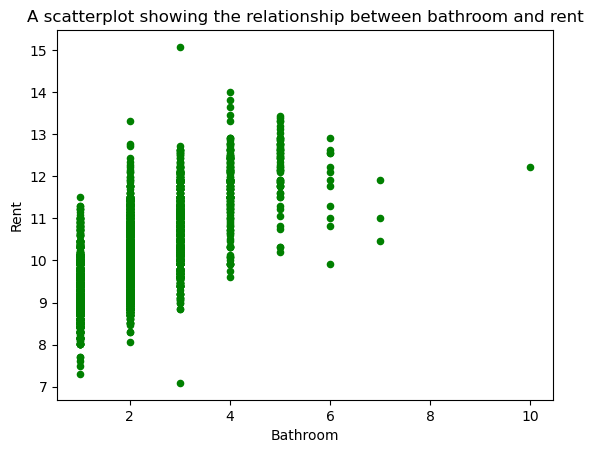

In [18]:
subset= df1[[ 'Bathroom', 'Rent']];
scatter = subset.plot(x = 'Bathroom', y = 'Rent', kind='scatter', c ='green');
scatter.set_title("A scatterplot showing the relationship between bathroom and rent");

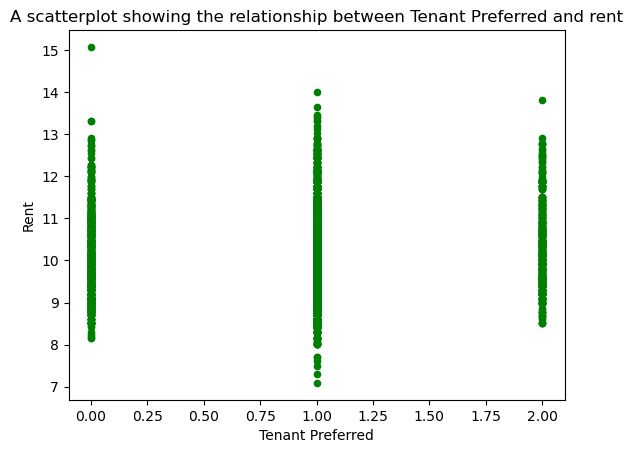

In [19]:
subset = df1[['Tenant Preferred', 'Rent']]
scatter= subset.plot(x = 'Tenant Preferred', y = 'Rent', kind='scatter', c= 'green'); 
scatter.set_title("A scatterplot showing the relationship between Tenant Preferred and rent");

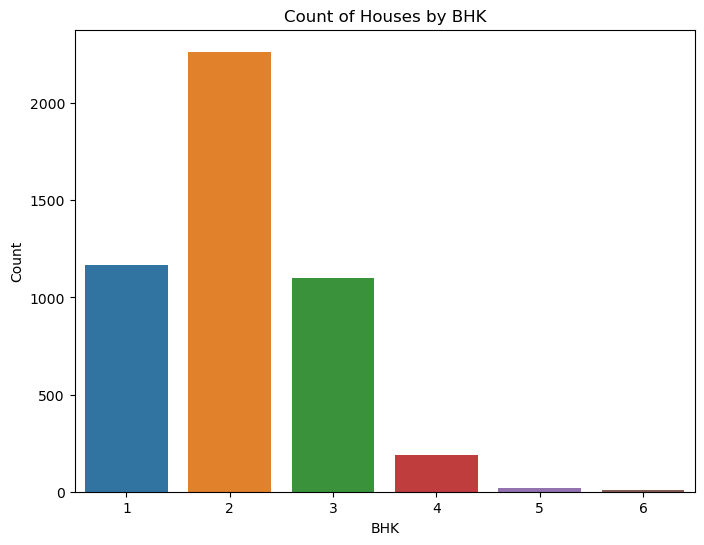

In [20]:
#Count of Houses by BHK

plt.figure(figsize=(8, 6))
sns.countplot(x='BHK', data=df1) 
plt.title("Count of Houses by BHK") 
plt.ylabel("Count")
plt.xlabel("BHK")
plt.show()

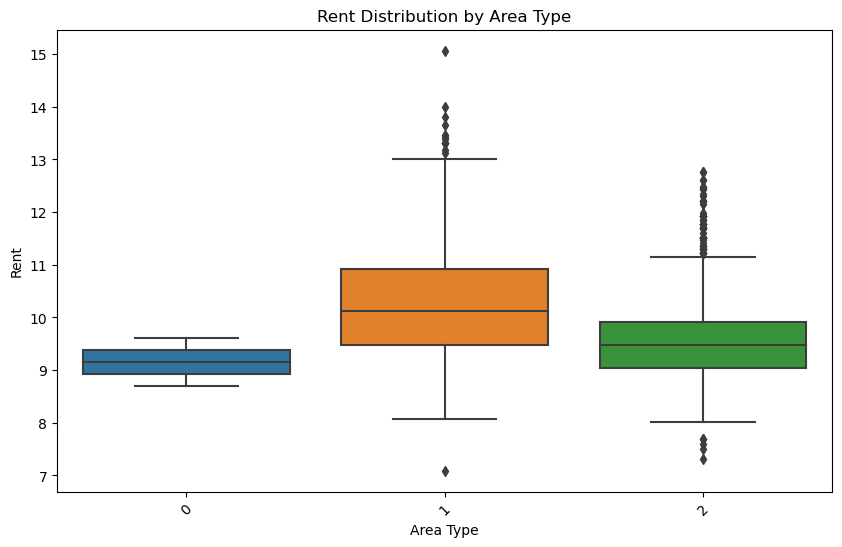

In [21]:
#Rent distribution by area type

plt.figure(figsize=(10, 6))
sns.boxplot(x='Area Type', y='Rent', data=df1)
plt.title("Rent Distribution by Area Type")
plt.xlabel("Area Type")
plt.ylabel("Rent")
plt.xticks(rotation=45)
plt.show()

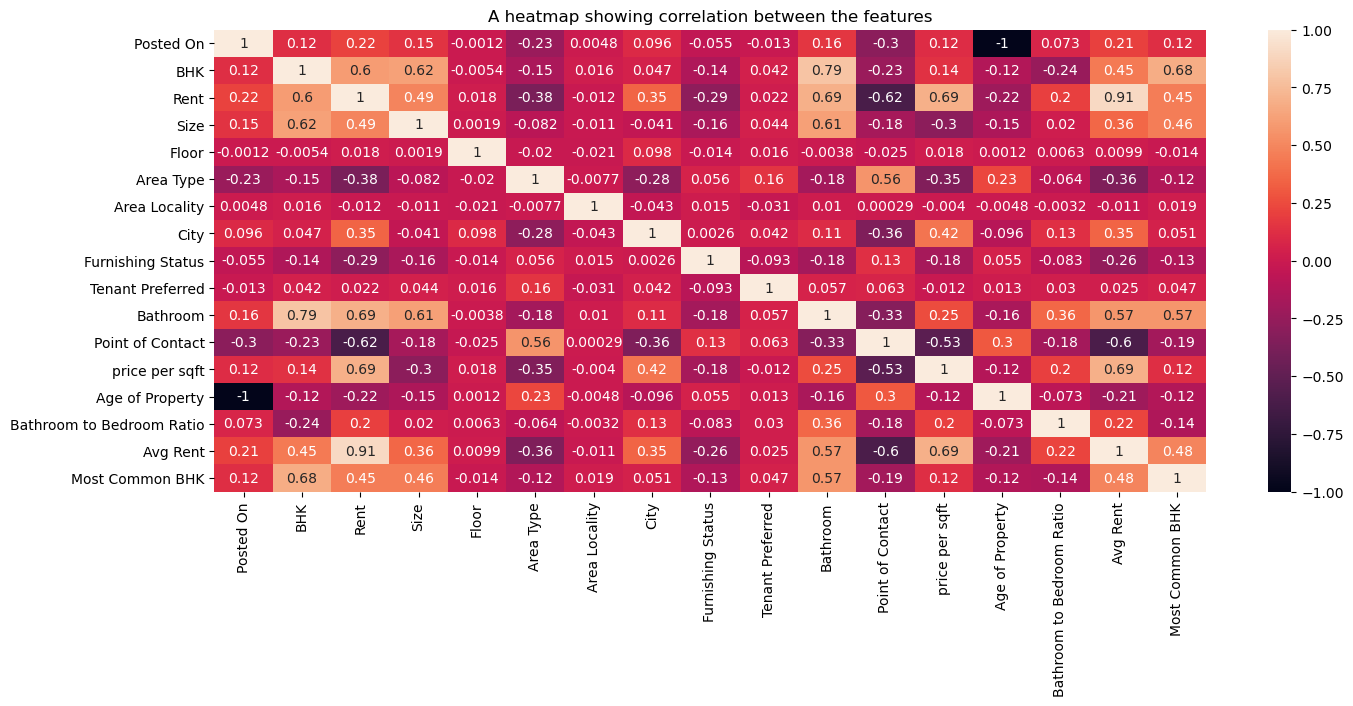

In [22]:

#visualizing the correlation of the features
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(), annot=True)
plt.title("A heatmap showing correlation between the features")
plt.show()
     

In [23]:
#splitting data
X = df.drop(['Posted On', 'Rent'], axis=1).values
y = df['Rent'].values


X.shape

(4746, 15)

In [24]:
y.shape

(4746,)

In [25]:
from sklearn.metrics import mean_squared_error
def rmse(ytest, ypred):
  result = np.sqrt(mean_squared_error(ytest, ypred))
  return result
     

def r2score(model):
  score = model.score(rescaledX_test, y_test)
  return score
     
#split data into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
#Feature Scaling

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

In [27]:
#Linear Regression

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(rescaledX_train, y_train)

LinearRegression()

In [28]:
y_pred_lr = lr.predict(rescaledX_test)
r2score(lr)

0.9997329736431114

In [29]:

rmse(y_test, y_pred_lr)

0.015342870983716728

In [30]:
#Decision Tree

from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(min_samples_split=10, max_depth=15)
tree.fit(rescaledX_train, y_train)

DecisionTreeRegressor(max_depth=15, min_samples_split=10)

In [31]:
y_pred_tree = tree.predict(rescaledX_test)
r2score(tree)


0.9479578801215683

In [32]:
rmse(y_test, y_pred_tree)

0.2141938796552832

In [33]:
#Random forest
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=10, n_jobs=-1, random_state=0)
forest.fit(rescaledX_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_split=10, n_estimators=200,
                      n_jobs=-1, random_state=0)

In [34]:
y_pred_forest = forest.predict(rescaledX_test)
r2score(forest)

0.9714710912270682

In [35]:
rmse(y_test, y_pred_forest)

0.15858866672582708

In [ ]:
#Hyperparameter tuning


from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 20, 30]
}

# Initialize the Random Forest model
forest = RandomForestRegressor(random_state=0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(rescaledX_train, y_train)

# Get the best hyperparameter values and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print('Best Hyperparameters:', best_params)

# Fit the best model on the training data
best_model.fit(rescaledX_train, y_train)